## S&P 500 price prediction
- Prediction of S&P 500 future prices modeled as a regression problem.
- Using a MLP neural network.
- Using SPY ETF data from Kaggle: https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

In [1]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import keras
from keras import backend as K
import datetime as dt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
import os

RAND_SEED = 1
np.random.seed(RAND_SEED)

BASE_PATH = "/Users/matias.leone/Documents/Jupyter notebooks/"

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Load S&P 500 data from SPY ETF

In [2]:
# Load SPY ETF data from Kaggle data set
def load_symbol_df(dir_path, file_name):
    full_path = dir_path + file_name
    if os.stat(full_path).st_size > 0: 
        df = pd.read_csv(full_path)
        columns = list(df.columns.values)
        symbol = file_name.split(".")[0]
        df["Symbol"] = "sp500"
        columns.insert(0, "Symbol")
        return df[columns]
    
df = load_symbol_df(BASE_PATH + "data/us_stocks/ETFs/", "spy.us.txt")
df = df.sort_values(by="Date")
print("Dates: {}, from: {}, to: {}".format(len(df), df["Date"].min(), df["Date"].max()))

Dates: 3201, from: 2005-02-25, to: 2017-11-10


#### Functions to create samples

In [6]:
# Create train and test set
def prices_to_train_test_set(prices, trainSetProportion, windowLength, predDaysForward):
    X, Y = prices_to_samples(prices, windowLength, predDaysForward)
    return train_test_split(X, Y, test_size=1-trainSetProportion, random_state=RAND_SEED)

def prices_to_samples(prices, windowLength, predDaysForward):
    X_data = []
    Y_data = []
    totalSamples = 0
    endIdx = len(prices) - windowLength + 1 - predDaysForward    
    for i in range(0, endIdx):
        X, Y = to_XY(prices, i, windowLength, predDaysForward)
        X_data.append(X)
        Y_data.append(Y)
        totalSamples += 1
    return (np.array(X_data).reshape((totalSamples, windowLength)), np.array(Y_data).reshape((totalSamples, predDaysForward)))

def prices_to_percentage(prices, base_price):
    base_price = max(base_price, 0.001)
    return ((prices - base_price) / base_price).astype("float32")

def percentage_to_prices(percentages, base_price):
    base_price = max(base_price, 0.001)
    return (base_price * (1.0 + percentages)).astype("float32")

def to_X(prices, startIdx, windowLength):
    winEndIdx = startIdx + windowLength
    return prices_to_percentage(prices[startIdx:winEndIdx], prices[winEndIdx - 1])
    #return prices[startIdx:winEndIdx].astype("float32")

def to_Y(prices, startIdx, windowLength, predDaysForward):
    predStartIdx = startIdx + windowLength
    predEndIdx = predStartIdx + predDaysForward
    return prices_to_percentage(prices[predStartIdx:predEndIdx], prices[predStartIdx - 1])
    #return prices[predStartIdx:predEndIdx].astype("float32")
    
def to_XY(prices, startIdx, windowLength, predDaysForward):
    return (to_X(prices, startIdx, windowLength), to_Y(prices, startIdx, windowLength, predDaysForward))

def split_prices_by_date(df, date_threshold):
    return (df[df["Date"] < date_threshold]["Close"].values, df[df["Date"] >= date_threshold]["Close"].values)

#### Define network architecture

In [24]:
# Train model with the given parameters
def test_model(prices, windowLength, predDaysForward, epochs):
    print("Testing model with windowLength: {} and predDaysForward: {}".format(windowLength, predDaysForward))
    
    # Create train/test set
    print("Creating samples...")
    X_train, X_test, Y_train, Y_test = prices_to_train_test_set(prices, 0.8, windowLength, predDaysForward)
    print("Samples - Total: {}, Train:{}, Test: {}".format(len(Y_train) + len(Y_test), len(Y_train), len(Y_test)))
    
    # Create Keras model
    model = keras.models.Sequential([
        keras.layers.Dense(256, input_shape=(windowLength,), activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(predDaysForward)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    
    # Callbacks
    def print_progress(epoch, logs):
        if epoch % 10 == 0:
            loss = logs["loss"]*100
            val_loss = logs["val_loss"]*100
            print("\tEpoch {}, Loss: {}%, Val Loss: {}%".format(epoch, round(loss,6), round(val_loss,6)))
        
    model_base_path = BASE_PATH + "models/"
    if not os.path.exists(model_base_path):
        os.makedirs(model_base_path)
    model_path = model_base_path + "sp500reg_history{}_forward{}".format(windowLength, predDaysForward)
    fit_callbacks = [
        keras.callbacks.ModelCheckpoint(model_path, monitor="loss", save_weights_only=True),
        keras.callbacks.LambdaCallback(on_epoch_end = lambda epoch, logs: print_progress(epoch, logs))
    ]
    
    # Train model
    print("Training...")
    BATCH_SIZE = 128
    history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=epochs, verbose=0, callbacks=fit_callbacks, validation_data=(X_test, Y_test))
    print("Training done")
    
    # Get predictions
    print("Predicting...")
    score_train = model.evaluate(X_train, Y_train, verbose=0)
    score_test = model.evaluate(X_test, Y_test, verbose=0)
    print("Train loss: {}%, Test loss: {}%".format(round(score_train*100, 6), round(score_test*100, 6)))
    
    # Save results
    res = {
        "model": model,
        "windowLength": windowLength,
        "predDaysForward": predDaysForward,
        "score_train": score_train,
        "score_test": score_test
    }
    
    # Plot training
    plot_training_progress(history)
    
    return res

# Plot loss during training
def plot_training_progress(history):
    y_loss = np.array(history.history["loss"]) * 100.0
    y_val_loss = np.array(history.history["val_loss"]) * 100.0
    x = np.arange(len(y_loss))
    fig, ax = plt.subplots(1,1, figsize=(20,8))
    plt.scatter(x, y_loss, c="red", label="Train loss")
    plt.plot(x, y_loss, color="red")
    plt.scatter(x, y_val_loss, c="blue", label="Val loss")
    plt.plot(x, y_val_loss, color="blue")
    plt.title("Training progress")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    

#### Functions to test results and backtest predictions

In [11]:
# Function to show predicted return for specific symbol/date
def predict_return_by_date(symbol, prices_df, date, windowLength, predDaysForward, model, show_history=1.0):
    plot_num_hist_dates = int(windowLength * show_history)
    
    symbol_prices_df = prices_df[prices_df.Symbol == symbol][["Date", "Close"]].sort_values(by="Date")
    all_dates = symbol_prices_df.Date.values
    all_prices = symbol_prices_df.Close.values
    
    # Search current date
    current_date_search = np.nonzero(all_dates == date)[0]
    if len(current_date_search) == 0:
        print("No data for date: {}. Next business day: {}".format(date, next_business_day(date)))
        return
    current_date_idx = current_date_search[0]
    
    # Search first and prediction date
    first_date_idx = current_date_idx - windowLength + 1
    if first_date_idx < 0:
        print("Not enough historical data for date: {}. Oldest date: {}. Next business day: {}",format(date, all_dates[0], next_business_day(date)))
        return
    
    # Check if we have historical data to validate prediction
    last_pred_date_idx = current_date_idx + predDaysForward
    has_pred_date = last_pred_date_idx < len(all_dates)
    last_pred_date = all_dates[last_pred_date_idx] if has_pred_date else next_business_days(date, predDaysForward)[predDaysForward-1]
    
    # Predict future values
    X = to_X(all_prices, first_date_idx, windowLength).reshape((1, windowLength))
    Y_pred = model.predict(X)[0]
    Y_pred_prices = percentage_to_prices(Y_pred, all_prices[current_date_idx])
    Y_real_prices = all_prices[current_date_idx + 1 : last_pred_date_idx + 1] if has_pred_date else np.zeros(predDaysForward)
    mse = np.power(Y_real_prices - Y_pred_prices, 2).sum() / len(Y_real_prices)

    # Print summary
    print("{} - Current date: {}, Historical data since: {} ({} days), Price: ${}".format(symbol, date, all_dates[first_date_idx], windowLength, round(all_prices[current_date_idx],2)))
    print("Prediction for +{} days - {}: ${}".format(predDaysForward, last_pred_date, round(Y_pred_prices[-1],2)))
    print("Error: ${}".format(np.round(mse,4)))
    
    
    # Gather results
    report_data = []
    report_data.append([date, round(all_prices[current_date_idx],2), "0", 0])
    for i in range(0, predDaysForward):
        date_idx = current_date_idx + 1 + i
        next_date = all_dates[date_idx] if has_pred_date else next_business_days(date, i + 1)[i - 1]
        report_data.append([next_date, 
                            round(Y_real_prices[i],2), 
                            round(Y_pred_prices[i],2), 
                            round(Y_real_prices[i] - Y_pred_prices[i],2), 
                           ])
    report_df = pd.DataFrame(report_data, columns=["Date", "Price", "Prediction", "Diff"]) 
    
    # Plot historical prices
    fig, ax = plt.subplots(1,1, figsize=(20,8))
    plot_first_date_idx = current_date_idx - plot_num_hist_dates + 1
    plot_labels = np.append(all_dates[plot_first_date_idx : current_date_idx + 1], next_business_days(date, predDaysForward))
    #ax.set_xticklabels(plot_labels, rotation='horizontal')
    x_plot_hist = np.arange(plot_first_date_idx, current_date_idx + 1) - plot_first_date_idx
    y_plot_hist = all_prices[plot_first_date_idx : current_date_idx + 1]
    plt.plot(x_plot_hist, y_plot_hist, color="blue")
    plt.scatter(x_plot_hist, y_plot_hist, c="blue")
    
    # Plot vertical line to delimit historic vs prediction
    plt.axvline(x=current_date_idx - plot_first_date_idx, linestyle="--", color="gray")
    
    # Plot prediction
    x_plot_pred = np.arange(current_date_idx + 1, last_pred_date_idx + 1) - plot_first_date_idx
    plt.plot(x_plot_pred, Y_pred_prices, color="red")
    plt.scatter(x_plot_pred, Y_pred_prices, c="red")
    plt.plot([current_date_idx, current_date_idx+1]-plot_first_date_idx, [all_prices[current_date_idx], Y_pred_prices[0]], color="red", linestyle=":")
    
    # Plot actual future values (if available)
    if has_pred_date:
        plt.plot(x_plot_pred, Y_real_prices, color="green")
        plt.scatter(x_plot_pred, Y_real_prices, c="green")
        plt.plot([current_date_idx, current_date_idx+1]-plot_first_date_idx, all_prices[current_date_idx:current_date_idx+2], color="green", linestyle=":")
    
    # Show all
    plt.show()
    display(HTML(report_df.to_html(index=False) ))

    
def next_business_day(date_str):
    date_format = "%Y-%m-%d"
    date = dt.datetime.strptime(date_str, date_format)
    shift = dt.timedelta(1 + ((date.weekday()//4)*(6-date.weekday())))
    return dt.datetime.strftime(date + shift, date_format)

def next_business_days(date_str, n):
    days = []
    for i in range(n):
        date_str = next_business_day(date_str)
        days.append(date_str)
    return days


# Backtest a given model for a periods of dates
def backtest(df, since_date, windowLength, predDaysForward, model):
    # Find date to start evaluation
    first_eval_date = df[df["Date"] >= since_date].iloc[0]["Date"]
    first_eval_date_idx = df[df["Date"] == first_eval_date].index.item()
    all_dates = df.Date.values
    all_prices = df.Close.values
    total_dates_to_eval = len(all_dates) - first_eval_date_idx - predDaysForward
    
    # Create samples
    X = np.zeros((total_dates_to_eval, windowLength), dtype="float32")
    samples_ref = []
    for i in range(0, total_dates_to_eval):
        eval_idx = first_eval_date_idx + i
        last_win_idx = eval_idx - predDaysForward
        start_win_idx = last_win_idx - windowLength + 1
        X[i] = to_X(all_prices, start_win_idx, windowLength)
        samples_ref.append({
            "prev_date": all_dates[last_win_idx],
            "eval_date": all_dates[eval_idx],
            "prev_price": all_prices[last_win_idx],
            "eval_price": all_prices[eval_idx],
            "price_movement": all_prices[eval_idx] - all_prices[last_win_idx]
        })
        
    # Predict
    Y_pred = model.predict(X)
    
    # Check results for each day
    report_data = []
    y_plot_pred = np.zeros(total_dates_to_eval)
    y_plot_real = np.zeros(total_dates_to_eval)
    for i in range(total_dates_to_eval):
        ref = samples_ref[i]
        pred_return = Y_pred[i][0]
        prev_price = ref["prev_price"]
        real_price = ref["eval_price"]
        pred_price = prev_price * (1.0 + pred_return)
        price_diff = pred_price - real_price
        pred_return = (pred_price - prev_price) / prev_price * 100.0
        action = "Buy" if pred_return > 0.5 else "Nothing"
        profit = real_price - prev_price if action == "Buy" else 0
        report_data.append([ref["prev_date"], ref["eval_date"], round(prev_price,2), round(real_price,2), 
                            round(pred_price,2), round(price_diff,2), ref["price_movement"], 
                            action, round(profit,2), round(pred_return,2)])
        y_plot_pred[i] = pred_price
        y_plot_real[i] = real_price
    report_df = pd.DataFrame(report_data, columns=["PrevDate", "PredDate", "PrevPrice", "RealPrice", "PredPrice", "Diff", 
                                                   "PriceMove", "PredAction", "Profit", "PredReturn"]) 
    
    # Print some stats
    print("Backtesting since: {}, to: {}. Total dates: {}".format(first_eval_date, all_dates[first_eval_date_idx + total_dates_to_eval - 1], total_dates_to_eval))
    print("Profit: ${}, Buys: {}, Nothing: {}".format(
        round(report_df["Profit"].sum(), 2), 
        len(report_df[report_df["PredAction"] == "Buy"]),
        len(report_df[report_df["PredAction"] == "Nothing"])
    ))
    print("Worst loss: ${}. Total day losses: {}/{}".format(
        round(report_df["Profit"].min(), 2),
        len(report_df[report_df["Profit"] < 0]),
        len(report_df)
    ))
    print("Best profit: ${}. Total day wins: {}/{}".format(
        round(report_df["Profit"].max(), 2),
        len(report_df[report_df["Profit"] > 0]),
        len(report_df)
    ))
    
    # Plot prices
    fig, ax = plt.subplots(1,1, figsize=(20,8))
    x_plot = np.arange(total_dates_to_eval)
    plt.plot(x_plot, y_plot_real, color="green")
    plt.scatter(x_plot, y_plot_real, c="green", label="Real")
    plt.plot(x_plot, y_plot_pred, color="red")
    plt.scatter(x_plot, y_plot_pred, c="red", label="Prediction")
    plt.title("Real vs Prediction")
    plt.xlabel("Time")
    plt.ylabel("Price $")
    plt.legend()
    plt.show()
    
    # Display details
    display(HTML(report_df.to_html(index=False)))
    

#### Train model

Testing model with windowLength: 260 and predDaysForward: 30
Creating samples...
Samples - Total: 2694, Train:2155, Test: 539
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               66816     
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_27 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_28 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 30)                7710      
Total params: 27

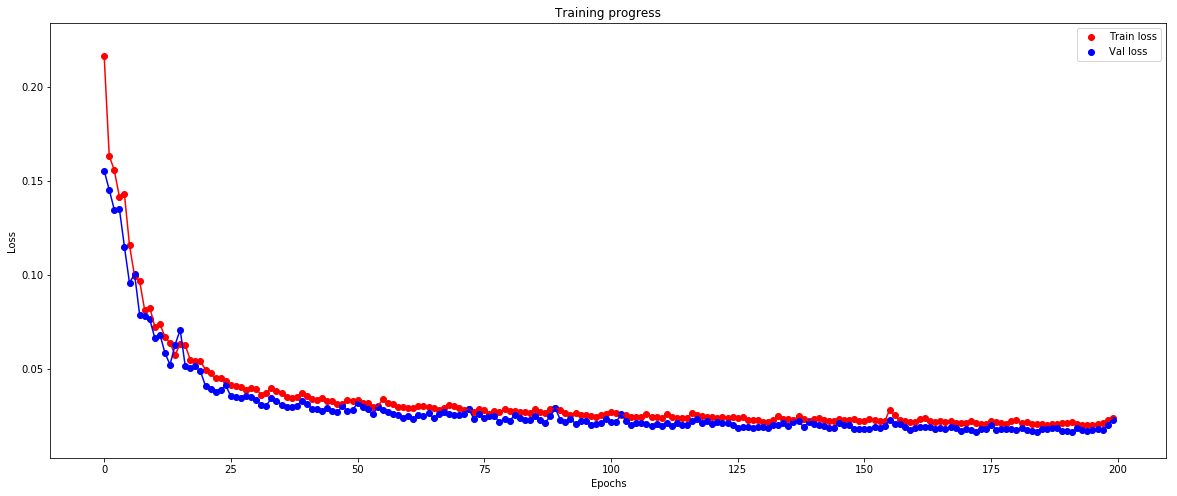

In [25]:
# Don't use latest year for training
recent_prices_date = "2017-01-01"
old_prices, recent_prices = split_prices_by_date(df, recent_prices_date)

# Train model
WINDOW_SIZE = 260 # How many past days we take into account
FORWARD_DAYS = 30 # How many days into the future we try to predict
EPOCHS = 200
result = test_model(old_prices, WINDOW_SIZE, FORWARD_DAYS, EPOCHS)
model = result["model"]

#### Check results

Backtesting since: 2017-01-03, to: 2017-09-29. Total dates: 188
Profit: $59.03, Buys: 7, Nothing: 181
Worst loss: $0.0. Total day losses: 0/188
Best profit: $9.82. Total day wins: 7/188


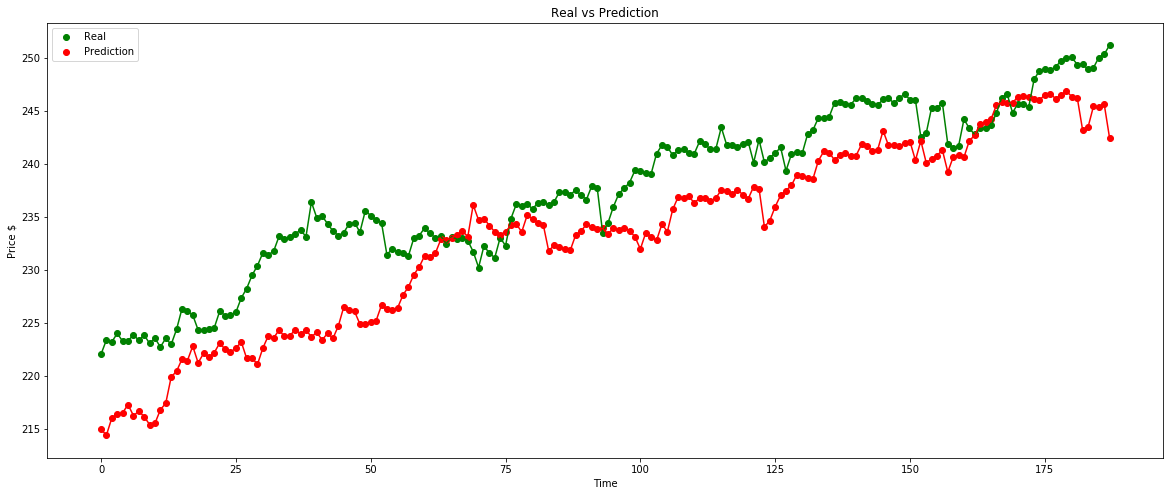

PrevDate,PredDate,PrevPrice,RealPrice,PredPrice,Diff,PriceMove,PredAction,Profit,PredReturn
2016-11-17,2017-01-03,214.66,222.07,214.96,-7.11,7.41,Nothing,0.00,0.14
2016-11-18,2017-01-04,214.17,223.41,214.43,-8.98,9.24,Nothing,0.00,0.12
2016-11-21,2017-01-05,215.78,223.23,216.04,-7.19,7.45,Nothing,0.00,0.12
2016-11-22,2017-01-06,216.21,224.02,216.38,-7.64,7.81,Nothing,0.00,0.08
2016-11-23,2017-01-09,216.33,223.29,216.54,-6.75,6.96,Nothing,0.00,0.10
2016-11-25,2017-01-10,217.14,223.29,217.30,-5.99,6.15,Nothing,0.00,0.07
2016-11-28,2017-01-11,216.11,223.91,216.28,-7.63,7.80,Nothing,0.00,0.08
2016-11-29,2017-01-12,216.54,223.36,216.66,-6.70,6.82,Nothing,0.00,0.06
2016-11-30,2017-01-13,216.01,223.86,216.18,-7.68,7.85,Nothing,0.00,0.08
2016-12-01,2017-01-17,215.22,223.08,215.42,-7.66,7.86,Nothing,0.00,0.09


In [26]:
# Backtest
backtest(df, recent_prices_date, WINDOW_SIZE, FORWARD_DAYS, model)

sp500 - Current date: 2017-01-03, Historical data since: 2015-12-22 (260 days), Price: $222.07
Prediction for +30 days - 2017-02-15: $227.7100067138672
Error: $2.5933


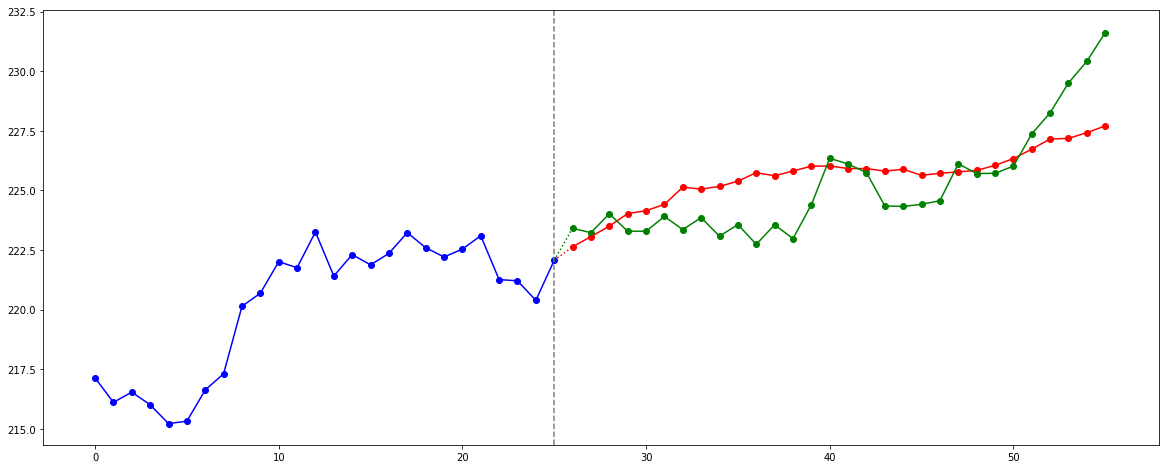

Date,Price,Prediction,Diff
2017-01-03,222.07,0,0.00
2017-01-04,223.41,222.64,0.77
2017-01-05,223.23,223.06,0.17
2017-01-06,224.02,223.5,0.52
2017-01-09,223.29,224.03,-0.74
2017-01-10,223.29,224.15,-0.86
2017-01-11,223.91,224.42,-0.51
2017-01-12,223.36,225.14,-1.78
2017-01-13,223.86,225.06,-1.20
2017-01-17,223.08,225.17,-2.09


sp500 - Current date: 2017-02-28, Historical data since: 2016-02-18 (260 days), Price: $233.16
Prediction for +30 days - 2017-04-11: $235.85000610351562
Error: $5.9904


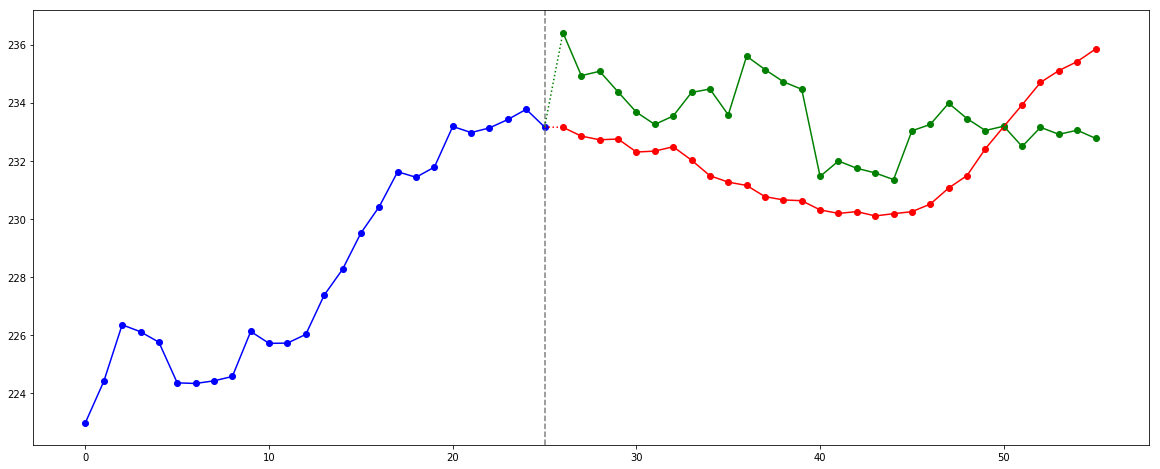

Date,Price,Prediction,Diff
2017-02-28,233.16,0,0.00
2017-03-01,236.41,233.15,3.26
2017-03-02,234.93,232.85,2.08
2017-03-03,235.08,232.72,2.36
2017-03-06,234.37,232.75,1.62
2017-03-07,233.67,232.3,1.37
2017-03-08,233.25,232.33,0.92
2017-03-09,233.54,232.48,1.06
2017-03-10,234.35,232.02,2.33
2017-03-13,234.47,231.48,2.99


sp500 - Current date: 2017-04-03, Historical data since: 2016-03-23 (260 days), Price: $233.04
Prediction for +30 days - 2017-05-16: $241.72000122070312
Error: $18.6174


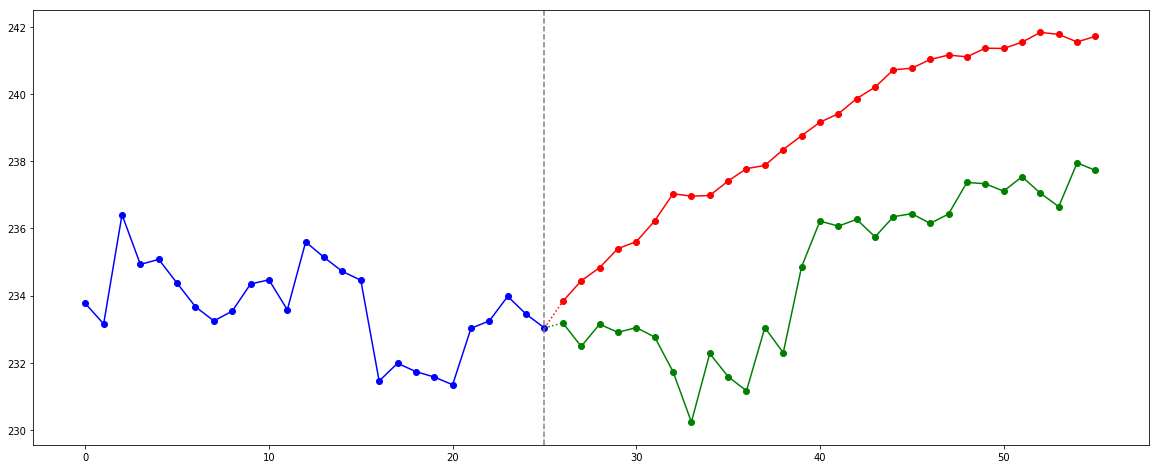

Date,Price,Prediction,Diff
2017-04-03,233.04,0,0.00
2017-04-04,233.19,233.83,-0.64
2017-04-05,232.49,234.44,-1.95
2017-04-06,233.15,234.83,-1.68
2017-04-07,232.91,235.4,-2.49
2017-04-10,233.05,235.61,-2.56
2017-04-11,232.77,236.23,-3.46
2017-04-12,231.74,237.03,-5.29
2017-04-13,230.24,236.96,-6.72
2017-04-17,232.28,236.98,-4.70


sp500 - Current date: 2017-06-01, Historical data since: 2016-05-20 (260 days), Price: $240.99
Prediction for +30 days - 2017-07-14: $238.8000030517578
Error: $16.4948


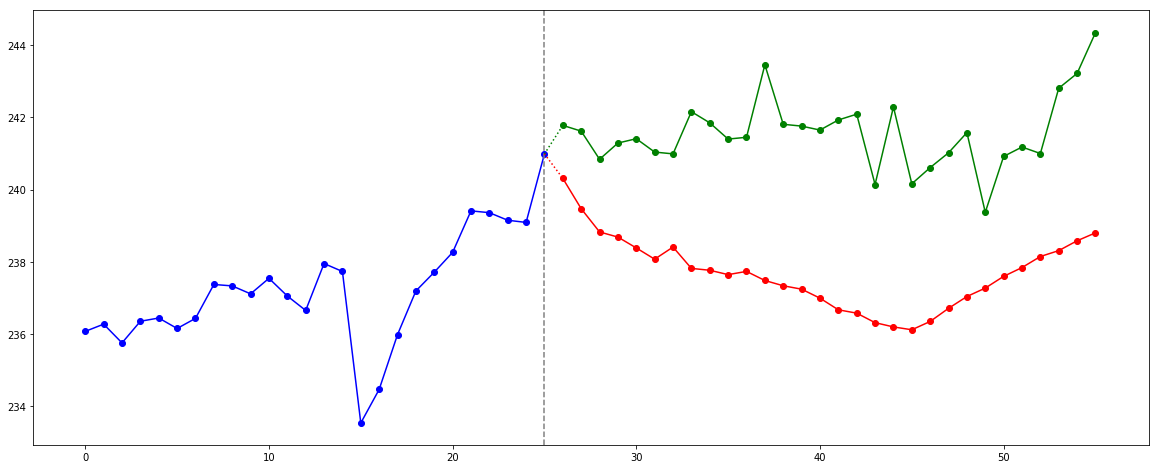

Date,Price,Prediction,Diff
2017-06-01,240.99,0,0.00
2017-06-02,241.78,240.31,1.47
2017-06-05,241.62,239.47,2.15
2017-06-06,240.84,238.83,2.01
2017-06-07,241.29,238.68,2.61
2017-06-08,241.41,238.38,3.03
2017-06-09,241.04,238.07,2.97
2017-06-12,240.99,238.41,2.58
2017-06-13,242.16,237.82,4.34
2017-06-14,241.85,237.76,4.09


sp500 - Current date: 2017-08-01, Historical data since: 2016-07-21 (260 days), Price: $246.1
Prediction for +30 days - 2017-09-13: $253.17999267578125
Error: $45.8161


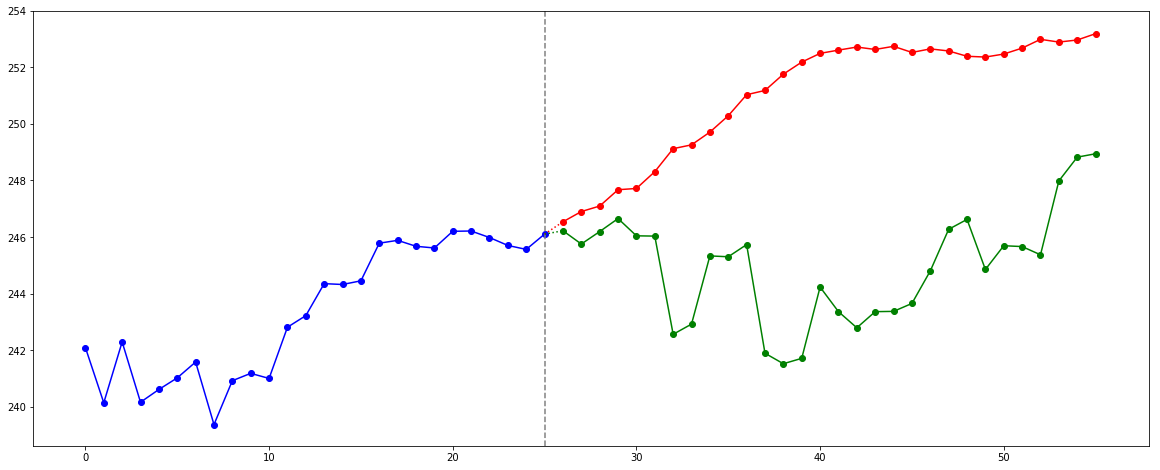

Date,Price,Prediction,Diff
2017-08-01,246.10,0,0.00
2017-08-02,246.22,246.54,-0.32
2017-08-03,245.75,246.9,-1.15
2017-08-04,246.19,247.09,-0.90
2017-08-07,246.65,247.67,-1.02
2017-08-08,246.04,247.71,-1.67
2017-08-09,246.03,248.31,-2.28
2017-08-10,242.56,249.12,-6.56
2017-08-11,242.92,249.25,-6.33
2017-08-14,245.33,249.71,-4.38


sp500 - Current date: 2017-10-02, Historical data since: 2016-09-21 (260 days), Price: $252.32
Prediction for +30 days - 2017-11-13: $256.8699951171875
Error: $64559.1737


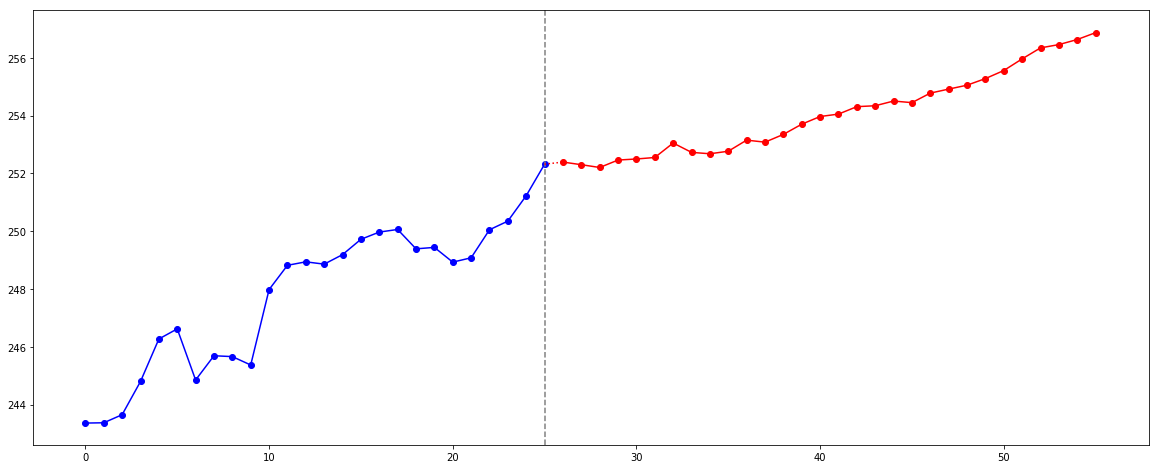

Date,Price,Prediction,Diff
2017-10-02,252.32,0,0.00
2017-10-03,0.00,252.39,-252.39
2017-10-03,0.00,252.3,-252.30
2017-10-04,0.00,252.21,-252.21
2017-10-05,0.00,252.46,-252.46
2017-10-06,0.00,252.5,-252.50
2017-10-09,0.00,252.55,-252.55
2017-10-10,0.00,253.05,-253.05
2017-10-11,0.00,252.73,-252.73
2017-10-12,0.00,252.68,-252.68


sp500 - Current date: 2017-10-10, Historical data since: 2016-09-29 (260 days), Price: $254.62
Prediction for +30 days - 2017-11-21: $258.5400085449219
Error: $66394.3535


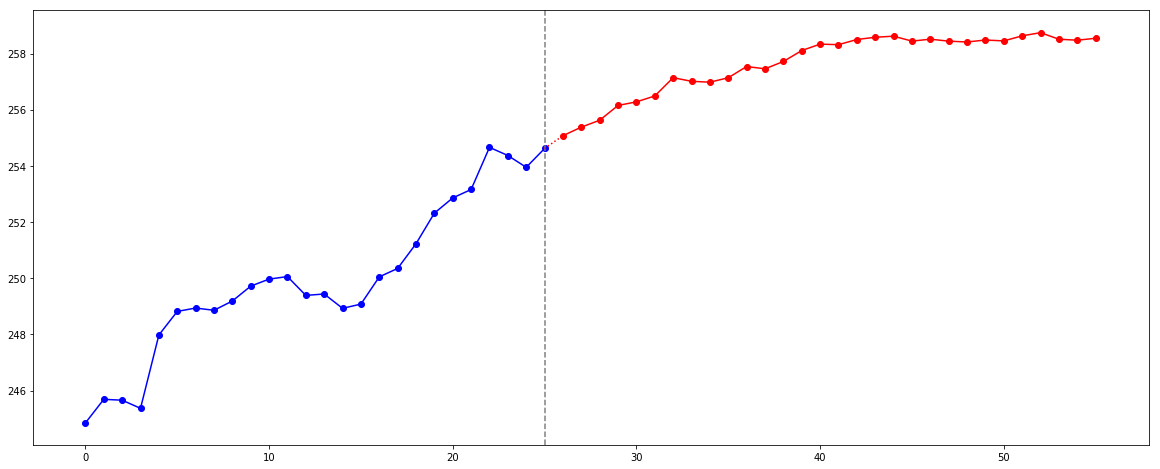

Date,Price,Prediction,Diff
2017-10-10,254.62,0,0.00
2017-10-11,0.00,255.08,-255.08
2017-10-11,0.00,255.38,-255.38
2017-10-12,0.00,255.63,-255.63
2017-10-13,0.00,256.15,-256.15
2017-10-16,0.00,256.28,-256.28
2017-10-17,0.00,256.49,-256.49
2017-10-18,0.00,257.14,-257.14
2017-10-19,0.00,257.01,-257.01
2017-10-20,0.00,256.98,-256.98


In [27]:
show_history_size = 0.1
predict_return_by_date("sp500", df, "2017-01-03", WINDOW_SIZE, FORWARD_DAYS, model, show_history_size)
predict_return_by_date("sp500", df, "2017-02-28", WINDOW_SIZE, FORWARD_DAYS, model, show_history_size)
predict_return_by_date("sp500", df, "2017-04-03", WINDOW_SIZE, FORWARD_DAYS, model, show_history_size)
predict_return_by_date("sp500", df, "2017-06-01", WINDOW_SIZE, FORWARD_DAYS, model, show_history_size)
predict_return_by_date("sp500", df, "2017-08-01", WINDOW_SIZE, FORWARD_DAYS, model, show_history_size)
predict_return_by_date("sp500", df, "2017-10-02", WINDOW_SIZE, FORWARD_DAYS, model, show_history_size)
predict_return_by_date("sp500", df, "2017-10-10", WINDOW_SIZE, FORWARD_DAYS, model, show_history_size)